In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import pickle
from pathlib import Path
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
from matplotlib import colors

from falkon.kernels import GaussianKernel
from falkon import FalkonOptions

from experiment_helpers import *

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [3]:
from deeptime.clustering import KMeans
from deeptime.markov.msm import MaximumLikelihoodMSM

In [4]:
set_matplotlib_rc(18, 20, 22)

In [5]:
# To download these files, run data/get_alanine_dataset.py
files = [
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz",
    "alanine-dipeptide-3x250ns-heavy-atom-distances.npz",
]
# TODO: Change the directory
data_directory = "../datasets"

In [27]:
fig_save_path = Path("outputs/alanine/")
fig_save_path.mkdir(exist_ok=True)

### Load the data in memory.

The .npz files are comprised of three independent simulations ['arr_0', 'arr_1', 'arr_2']. Either of them can be used to train the model.

In [6]:
dihedrals, distances = [], []
for fname in ['arr_0', 'arr_1', 'arr_2']:
    dihedrals.append(np.load(os.path.join(data_directory, files[0]))[fname]) #Dihedral angles \phi and \psi
    distances.append(np.load(os.path.join(data_directory, files[1]))[fname]) #Distance between heavy atoms
dihedrals = torch.from_numpy(np.concatenate(dihedrals))
distances = torch.from_numpy(np.concatenate(distances))

In [7]:
dihedrals.shape, distances.shape, dihedrals.dtype

(torch.Size([750000, 2]), torch.Size([750000, 45]), torch.float32)

In [8]:
dihedrals = dihedrals.double() # Not sure if this is needed?
distances = distances.double()

In [9]:
feature_norm = torch.linalg.norm(distances, dim=0).view(1, -1)
feature_mean = torch.mean(distances, dim=0).view(1, -1)
distances -= feature_mean
distances /= feature_norm

### Split the data

In [10]:
def get_data_split(q, subsample, test_fraction, val_fraction, seed):
    np.random.seed(seed)
    data_x = distances[:-q]
    data_y = distances[q:]
    data_x = data_x[::subsample]
    data_y = data_y[::subsample]
    tot_n = data_x.shape[0]
    rnd_ids = np.random.permutation(tot_n)
    test_n = int(tot_n * test_fraction)
    val_n = int(tot_n * val_fraction)
    train_n = tot_n - test_n - val_n
    test_ids = rnd_ids[:test_n]
    train_ids = rnd_ids[test_n:test_n + train_n]
    val_ids = rnd_ids[-val_n:]
    train_x, train_y = data_x[train_ids], data_y[train_ids]
    test_x, test_y = data_x[test_ids], data_y[test_ids]
    val_x, val_y = data_x[val_ids], data_y[val_ids]
    return [
        (train_x, train_y),
        (val_x, val_y),
        (test_x, test_y),
    ]

In [11]:
q = 100
subsample = 1

In [12]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = get_data_split(
    q=q, subsample=subsample, test_fraction=1/5, val_fraction=1/5, seed=0
)
print(f"{train_x.shape[0]} training points")
print(f"{test_x.shape[0]} test points")
print(f"{val_x.shape[0]} validation points")

449940 training points
149980 test points
149980 validation points


### Train

In [16]:
model_args = {
    "pcr": {
        "num_components": 5,
        "M": 10000,
        "kernel":GaussianKernel(0.0015, opt=FalkonOptions(use_cpu=True)),
        "svd_solver": "full",
    },
    "rrr": {
        "penalty": 1e-9,
        "num_components": 5,
        "M": 10_000,
        "kernel": GaussianKernel(
            .0008,
            opt=FalkonOptions(use_cpu=True)
        ),
    },
    "full_rrr": {
        "tikhonov_reg": 1e-8,
        "rank": 5,
        "sigma": 0.2,
        "svd_solver": "full",
    },
    "full_pcr": {
        "rank": 5,
        "sigma": 0.2,
        "svd_solver": "full",
    }
}

In [17]:
model = "rrr"
torch.manual_seed(11)
np.random.seed(11)

est = train_est(train_x, train_y, kind=model, **model_args[model])

In [18]:
evals, efun_left, efun_right = est.eigenfunctions()
evals

[KeOps] Generating code for formula Sum_Reduction(Exp(((Var(0,45,0)/Var(3,1,2)-Var(1,45,1)/Var(3,1,2))|(Var(0,45,0)/Var(3,1,2)-Var(1,45,1)/Var(3,1,2)))*1/-2)*Var(2,5,1),0) ... OK
[pyKeOps] Compiling pykeops cpp 7de50c38a4 module ... OK


tensor([ 1.0000-0.j,  0.9239-0.j,  0.2365-0.j,  0.0028-0.j, -0.0052-0.j],
       dtype=torch.complex128)

In [19]:
tscales = -1 / np.log(evals.real)
tscales_real = tscales * q
print(f"Time-scales: {tscales_real[1:]}ps")

Time-scales: tensor([1263.0046,   69.3537,   16.9693,       nan], dtype=torch.float64)ps


/tmp/ipykernel_51925/410965074.py:1: RuntimeWarning: invalid value encountered in log
  tscales = -1 / np.log(evals.real)


In [20]:
plt_subsample = 5

In [23]:
# Correlation between the first eigenfunction and the first dihedral angle
data_efuns = efun_right(distances[::plt_subsample]).real
corr_l1 = np.corrcoef(data_efuns[:, 1], dihedrals[::plt_subsample, 0])[1, 0]
print(f"Correlation lambda_1: {corr_l1:.2f}")

[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
Correlation lambda_1: 0.62


In [24]:
est_rmse = torch.sqrt(torch.mean(torch.square(
    est.predict(test_x) - test_y
)))
print(f"RMSE = {est_rmse:.4e}")

[KeOps] Generating code for formula Sum_Reduction(Exp(((Var(0,45,0)/Var(3,1,2)-Var(1,45,1)/Var(3,1,2))|(Var(0,45,0)/Var(3,1,2)-Var(1,45,1)/Var(3,1,2)))*1/-2)*Var(2,45,1),0) ... OK
[pyKeOps] Compiling pykeops cpp ee970c0fdb module ... OK
RMSE = 7.8105e-05


In [25]:
save_model = True
model_name = (
    f"{model}_s{model_args[model]['kernel'].sigma.item()}_"
    f"m{model_args[model]['M']}_r{model_args[model]['num_components']}"
)

In [28]:
if save_model:
    print(f"Saving model {model_name}")
    with open(fig_save_path / f"{model_name}.pkl", "wb") as fh:
        pickle.dump(est, fh)
else:
    model_name = "pcr_m5k_full"
    with open(fig_save_path / f"{model_name}.pkl", "rb") as fh:
        est = pickle.load(fh)

Saving model rrr_s0.0008_m10000_r5


### Nice looking plots

In [29]:
def plot_evals(efun_vals, dihedrals, evals, fig, axes, vcenters=[.5, .5, 0], halfranges=[.5, .5, None]):
    cmap = plt.cm.coolwarm
    alpha = 0.1
    s = 0.2
    efun_vals = efun_vals.real

    for i in range(len(axes)):
        axes[i].scatter(
            dihedrals[:, 0], dihedrals[:, 1],
            c=efun_vals[:, i], s=s, cmap=cmap, alpha=alpha,
            norm=colors.CenteredNorm(vcenter=vcenters[i], halfrange=halfranges[i])
        )
        axes[i].set_title(f"$\lambda_{i + 1} = {evals[i + 1].real:.3f}$")
        axes[i].set_xticks([-np.pi, 0, np.pi])
        axes[i].set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
        axes[i].set_xlabel("$\phi$")
        axes[i].set_yticks([-np.pi, 0, np.pi])
        if i == 0:
            axes[i].set_yticklabels(["$-\pi$", "$0$", "$\pi$"])
            axes[i].set_ylabel("$\psi$")
        else:
            axes[i].set_yticklabels([])
        axes[i].set_aspect('equal')

def plot_pcca(efun_vals, dihedrals, fig, ax, n_clusters, n_pcca_clusters):
    alpha = 0.1
    s = 0.2
    efun_vals = efun_vals.numpy().real
    clustering = KMeans(n_clusters=n_clusters, fixed_seed=13).fit(
        efun_vals
    ).fetch_model()
    assignments = clustering.transform(efun_vals)
    msm = MaximumLikelihoodMSM().fit(assignments, lagtime=1).fetch_model()
    pcca = msm.pcca(n_metastable_sets=n_pcca_clusters)

    cmap = plt.cm.viridis
    scatter_out = ax.scatter(
        dihedrals[:, 0],
        dihedrals[:, 1],
        c=pcca.memberships[assignments].argmax(1),
        cmap=cmap, 
        s=s,
        alpha=alpha
    )
    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
    ax.set_xlabel("$\phi$")
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels(["$-\pi$", "$0$", "$\pi$"])
    # ax.set_ylabel("$\psi$")
    ax.set_aspect('equal')
    norm = colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(
        scatter_out,#plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax=ax,
        ticks=[0, 1, 2],
    )
    cbar.solids.set(alpha=1)
    cbar.ax.set_yticklabels(["$0$", "$1$", "$2$"])
    cbar.ax.set_ylabel("metastable state")

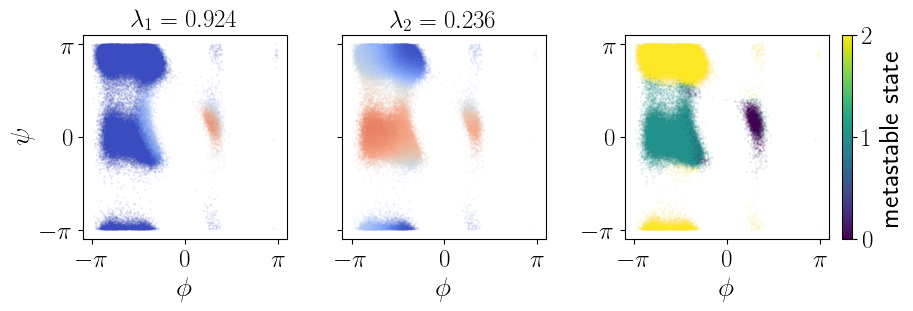

In [368]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3), constrained_layout=True)

plot_evals(
    data_efuns[:, 1:3], dihedrals[::plt_subsample], evals, fig, ax[:2],
    vcenters=[1.8, 0, -0.4, 0], halfranges=[1.5, None, None, None], 
)
plot_pcca(
    data_efuns[:, :3], dihedrals[::plt_subsample], fig, ax[2], n_clusters=75, n_pcca_clusters=3
)
fig.savefig(fig_save_path / "alanine.png", dpi=300, bbox_inches='tight')

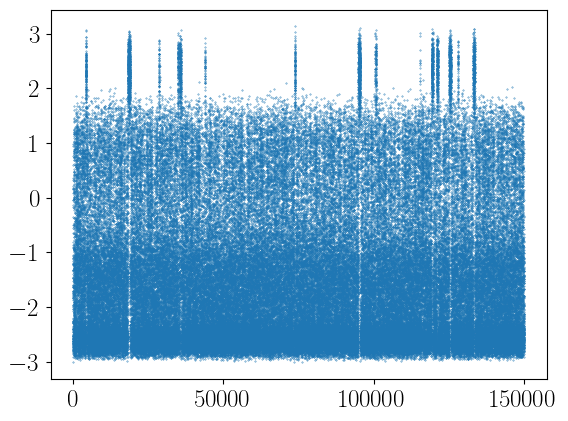

In [33]:
fig, ax = plt.subplots()
ax.scatter(np.arange(data_efuns.shape[0]), data_efuns[:, 1].real, s=0.1)
# ax.scatter(np.arange(dihedrals[::30].shape[0]), dihedrals[::30, 0], s=0.1)
# ax.scatter(np.arange(efun_vals.shape[0]), efun_vals[:, 2].real, s=0.1)

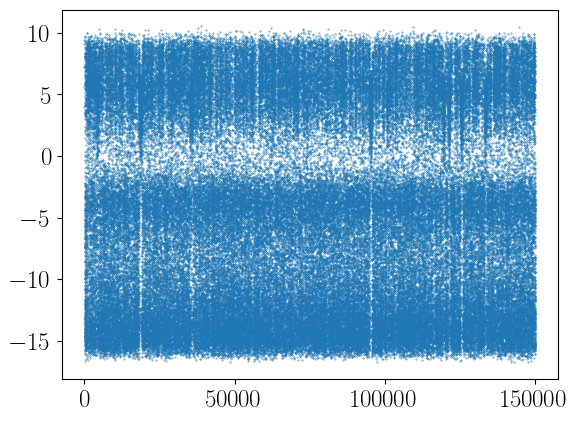

In [34]:
fig, ax = plt.subplots()
# ax.scatter(np.arange(efun_vals.shape[0]), efun_vals[:, 1].real, s=0.1)
ax.scatter(np.arange(data_efuns.shape[0]), data_efuns[:, 2].real, s=0.1)